In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)


In [3]:
# Define column names for the dataset
columns = (
    ['unit_number', 'time_cycles'] +
    [f'op_setting_{i}' for i in range(1, 4)] +
    [f'sensor_{i}' for i in range(1, 22)]
)


In [4]:
df = pd.read_csv(
    '../data/raw/train_FD001.txt',
    sep=' ',
    header=None
)

# Remove extra empty columns
df.drop(df.columns[-2:], axis=1, inplace=True)
df.columns = columns

df.head()


,unit_number,time_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [5]:
df.shape

(20631, 26)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   unit_number   20631 non-null  int64  
 1   time_cycles   20631 non-null  int64  
 2   op_setting_1  20631 non-null  float64
 3   op_setting_2  20631 non-null  float64
 4   op_setting_3  20631 non-null  float64
 5   sensor_1      20631 non-null  float64
 6   sensor_2      20631 non-null  float64
 7   sensor_3      20631 non-null  float64
 8   sensor_4      20631 non-null  float64
 9   sensor_5      20631 non-null  float64
 10  sensor_6      20631 non-null  float64
 11  sensor_7      20631 non-null  float64
 12  sensor_8      20631 non-null  float64
 13  sensor_9      20631 non-null  float64
 14  sensor_10     20631 non-null  float64
 15  sensor_11     20631 non-null  float64
 16  sensor_12     20631 non-null  float64
 17  sensor_13     20631 non-null  float64
 18  sensor_14     20631 non-nu

In [7]:

df['unit_number'].nunique()


100

In [8]:
# Time Cycle Distribution
df.groupby('unit_number')['time_cycles'].max().describe()

count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: time_cycles, dtype: float64

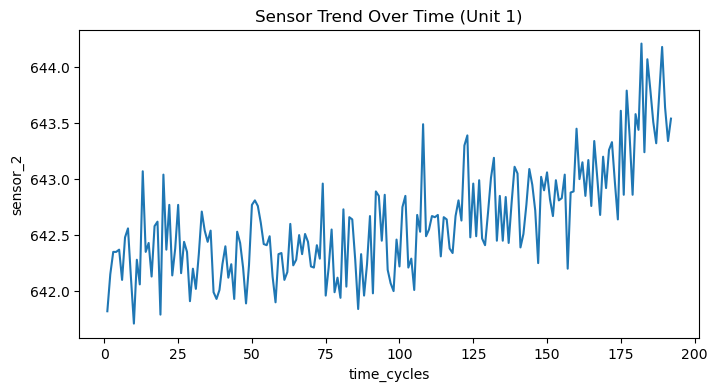

In [ ]:
# Quick Sensor Visualization
plt.figure(figsize=(8, 4))
sns.lineplot(
    data=df[df['unit_number'] == 1],
    x='time_cycles',
    y='sensor_2'
)
plt.title('Sensor Trend Over Time (Unit 1)')
plt.show()
# Sensor degradation trends over time indicate approaching failure, which justifies time-series feature engineering

In [10]:
# Calculate max cycle for each unit
rul_df = df.groupby('unit_number')['time_cycles'].max().reset_index()
rul_df.columns = ['unit_number', 'max_cycle']

# Merge back
df = df.merge(rul_df, on='unit_number')

# Remaining Useful Life
df['RUL'] = df['max_cycle'] - df['time_cycles']

df[['unit_number', 'time_cycles', 'RUL']].head()


,unit_number,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [11]:
# Failure risk if RUL <= 30 cycles
df['failure_risk'] = (df['RUL'] <= 30).astype(int)

df[['RUL', 'failure_risk']].value_counts().head()
# 30 cycles gives sufficient lead time for preventive maintenance.

RUL  failure_risk
0    1               100
65   0               100
96   0               100
95   0               100
94   0               100
dtype: int64

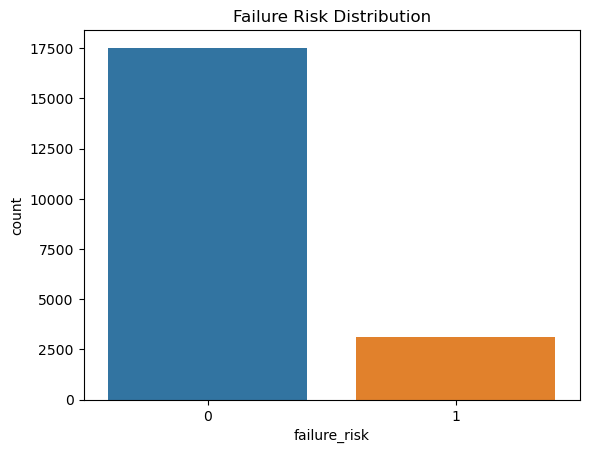

In [12]:
sns.countplot(x='failure_risk', data=df)
plt.title('Failure Risk Distribution')
plt.show()
# The dataset is imbalanced, so recall and ROC-AUC are more meaningful than accuracy

In [13]:
df_model = df.drop(columns=['max_cycle', 'RUL'])
df_model.head()
# RUL and max cycle are derived from future information and would cause data leakage.

,unit_number,time_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,failure_risk
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,0


In [14]:
sensor_cols = [col for col in df_model.columns if 'sensor_' in col]
sensor_cols[:5], len(sensor_cols)
# Raw sensor values are not enough.
# We will create features that capture degradation trends.

(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5'], 21)

In [15]:
# Rolling statistics capture gradual sensor drift leading to failure
window_size = 5

for col in sensor_cols:
    df_model[f'{col}_roll_mean'] = (
        df_model.groupby('unit_number')[col]
        .rolling(window=window_size)
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    df_model[f'{col}_roll_std'] = (
        df_model.groupby('unit_number')[col]
        .rolling(window=window_size)
        .std()
        .reset_index(level=0, drop=True)
    )


In [16]:
# Lag and delta features quantify abrupt changes in sensor behavior.
for col in sensor_cols:
    df_model[f'{col}_lag1'] = (
        df_model.groupby('unit_number')[col].shift(1)
    )
    df_model[f'{col}_diff'] = (
        df_model.groupby('unit_number')[col].diff()
    )


In [17]:
df_model.fillna(method='bfill', inplace=True)


In [18]:
df_model.shape

(20631, 111)

In [19]:
df_model.to_csv('../data/processed/vehicle_maintenance_features.csv', index=False)